В этой части проекта вам нужно написать несколько SQL-запросов в Jupyter Notebook. Эти задания проверят вручную, и вы получите комментарии к составленным запросам. 

Необходимые данные находятся в таблицах схемы `stackoverflow`. Не забудьте подключиться к базе с помощью SQLAlchemy. Вспомните инструкцию из [урока про представление результатов](https://practicum.yandex.ru/learn/data-analyst-plus/courses/96ccbf7a-b65d-4f51-b5f3-18360ad1e301/sprints/6116/topics/27f7c9a7-a474-4a82-8392-b3f069b26f69/lessons/e12d84bb-ffa8-490c-8bde-0935d86ceccb/). Пример кода для подключения к базе и выгрузки результатов вы найдёте и в этой тетрадке. 

Некоторые задания включают дополнительные вопросы — не пропустите их. На часть вопросов можно ответить текстом, а для некоторых понадобится визуализация. Помните, что результат запроса можно выгрузить в датафрейм. 

Чтобы ожидаемый результат было легче представить, мы добавили к каждому заданию небольшой фрагмент итоговой таблицы. В запросах вы можете использовать любые подходящие названия полей.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sqlalchemy import create_engine

In [2]:
sns.set(rc={"figure.figsize": (20, 12)})

### Конфигурация для подключения к базе данных `data-analyst-advanced-sql`
Эта база данных содержит схему `stackoverflow`, с которой вы будете работать в проекте

In [3]:
db_config = {
    "user": "praktikum_student",  # имя пользователя
    "pwd": "Sdf4$2;d-d30pp",  # пароль
    "host": "rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net",
    "port": 6432,  # порт подключения
    "db": "data-analyst-advanced-sql",  # название базы данных
}

connection_string = "postgresql://{}:{}@{}:{}/{}".format(
    db_config["user"],
    db_config["pwd"],
    db_config["host"],
    db_config["port"],
    db_config["db"],
)

Создание подключения

In [4]:
engine = create_engine(connection_string)

Пример запроса к базе данных

`sample_df` является pandas-датафреймом.

In [5]:
query = """
SELECT *
FROM stackoverflow.users
LIMIT 10;
"""

sample_df = pd.read_sql_query(query, con=engine)

In [6]:
sample_df

,id,creation_date,display_name,last_access_date,location,reputation,views
0,1,2008-07-31 14:22:31,Jeff Atwood,2018-08-29 02:34:23,"El Cerrito, CA",44300,408587
1,2,2008-07-31 14:22:31,Geoff Dalgas,2018-08-23 17:31:56,"Corvallis, OR",3491,23966
2,3,2008-07-31 14:22:31,Jarrod Dixon,2018-08-30 20:56:24,"Raleigh, NC, United States",13418,24396
3,4,2008-07-31 14:22:31,Joel Spolsky,2018-08-14 22:18:15,"New York, NY",28768,73755
4,5,2008-07-31 14:22:31,Jon Galloway,2018-08-29 16:48:36,"San Diego, CA",39172,11700
5,8,2008-07-31 21:33:24,Eggs McLaren,2018-04-09 02:04:56,None,942,6372
6,9,2008-07-31 21:35:27,Kevin Dente,2018-08-30 18:18:03,"Oakland, CA",14337,4949
7,11,2008-08-01 00:59:11,Anonymous User,2008-08-01 00:59:11,None,1890,2123
8,13,2008-08-01 04:18:05,Chris Jester-Young,2018-08-30 02:47:23,"Raleigh, NC, United States",177138,35414
9,17,2008-08-01 12:02:22,Nick Berardi,2018-01-22 01:35:38,"Issaquah, WA",44443,4786


# Задание 1

Выведите общую сумму просмотров постов за каждый месяц 2008 года. Если данных за какой-либо месяц в базе нет, такой месяц можно пропустить. Результат отсортируйте по убыванию общего количества просмотров.

| month_date  | total_views |
| ------------- | ------------- |
| 2008-09-01  | 452928568  |
| 2008-10-01  | 365400138  |
| ...         | ... |

In [7]:
query = """
SELECT
    DISTINCT date_trunc('month', creation_date) AS month_date,
    SUM(views_count) OVER (PARTITION BY date_trunc('month', creation_date)) AS total_views
FROM stackoverflow.posts
WHERE
    creation_date BETWEEN '2008-01-01' AND '2009-01-01'
ORDER BY total_views desc
"""

df = pd.read_sql_query(query, con=engine)

<details>

<summary>Подсказка</summary>
Используйте функцию для усечения даты, а затем сгруппируйте и отсортируйте данные.
</details>

Проанализируйте итоговую таблицу. Отличаются ли данные за разные месяцы? С чем могут быть связаны отличия?

In [8]:
df

,month_date,total_views
0,2008-09-01,452928568
1,2008-10-01,365400138
2,2008-11-01,221759651
3,2008-12-01,197792841
4,2008-08-01,131367083
5,2008-07-01,669895


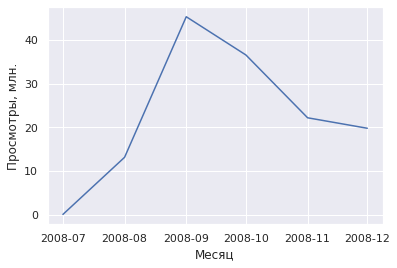

In [9]:
sns.set(rc={"figure.figsize": (16, 10)})
ax = sns.lineplot(x=df["month_date"], y=df["total_views"] / 10e6)
ax.set_xlabel("Месяц")
ax.set_ylabel("Просмотры, млн.");

Просмотры начинаются с июля месяца, очевидно, это месяц старта проекта. В первые 2 месяца число прпосмотров стремительно растёт, а после начинается замедляющийся спад, возможно, переходящиё в некое плато.

# Задание 2

Выведите имена самых активных пользователей, которые в первый месяц после регистрации (включая день регистрации) дали больше 100 ответов. Вопросы, которые задавали пользователи, не учитывайте. Для каждого имени пользователя выведите количество уникальных значений `user_id`. Отсортируйте результат по полю с именами в лексикографическом порядке.

| display_name | count |
| ------------ | ----- |
| 1800 INFORMATION | 1 |
| Adam Bellaire | 1 |
| Adam Davis | 1 |
| ... | ... |

In [10]:
query = """
WITH tbl AS (
        SELECT
            DISTINCT u.display_name,
            COUNT(p.id) OVER (PARTITION BY u.id) AS COUNT
        FROM stackoverflow.posts p
            JOIN stackoverflow.users u
            ON u.id = p.user_id
            JOIN stackoverflow.post_types pt
            ON pt.id = p.post_type_id
        WHERE
            pt.type = 'Answer' AND
            p.creation_date - u.creation_date <= '1 month':: INTERVAL
    )
SELECT *
FROM tbl
WHERE COUNT > 100
ORDER BY display_name
"""

df = pd.read_sql_query(query, con=engine)

In [11]:
df.head()

,display_name,count
0,1800 INFORMATION,101
1,Adam Bellaire,104
2,Adam Davis,123
3,Adam Liss,114
4,Amy B,133


In [12]:
df["count"].max()

379

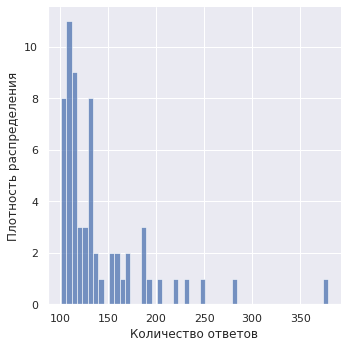

In [13]:
sns.set(rc={"figure.figsize": (16, 10)}) # почему-то не радобает именно на этом графике :(
ax = sns.displot(data=df, x="count", bins=50)
ax.set(xlabel="Количество ответов", ylabel="Плотность распределения");

<details>

<summary>Подсказка</summary>
Вам нужно присоединить несколько таблиц — изучите внимательнее описание базы. Чтобы добавить промежуток времени к дате, используйте ключевое слово INTERVAL, например, так: <дата> + INTERVAL '1 year 2 months 3 days'
.</details>

Какие аномалии наблюдаются в данных? О чём они говорят?

Форма распределения в целом напоминает пуассоновское, что, в целом, не удивительно. Но на графике наблюдаются выбросы, как в области сравнительно небольших значений (около 130), так и в области средних (район 180). Также единичный выбросы наблюдаются при количестве ответов больше 200: вплоть до 379.

# Задание 3

Выведите количество постов за 2008 год по месяцам. Отберите посты от пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года. Отсортируйте таблицу по значению месяца по убыванию.

| month | count |
| ------|------ |
| 2008-12-01 | 17641 |
| 2008-11-01 | 18294 |
| ... | ... |

In [14]:
query = """
WITH usrs AS (
        SELECT DISTINCT u.id
        FROM stackoverflow.users u
            JOIN stackoverflow.posts p
            ON u.id = p.user_id
        WHERE
            date_trunc('month', p.creation_date) = '2008-12-01'
    )
SELECT
    DISTINCT date_trunc('month', p.creation_date) AS MONTH,
    COUNT(p.id) OVER (PARTITION BY date_trunc('month', p.creation_date)) AS COUNT
FROM stackoverflow.posts p
    JOIN stackoverflow.users u
    ON date_trunc('month', u.creation_date) = '2008-09-01' AND u.id = p.user_id
WHERE
    date_trunc('year', p.creation_date) = '2008-01-01' AND
    u.id IN (
        SELECT *
        FROM usrs
    )
ORDER BY date_trunc('month', p.creation_date) desc
"""

df = pd.read_sql_query(query, con=engine)

<details>

<summary>Подсказка</summary>
Сначала найдите идентификаторы пользователей, которые зарегистрировались в сентябре 2008 года и оставили хотя бы один пост в декабре. Затем используйте результат для среза и посчитайте посты по месяцам.</details>

Изучите данные: есть ли в них аномалии? Предположите, почему могли появиться аномальные значения.

In [15]:
df

,month,count
0,2008-12-01,17641
1,2008-11-01,18294
2,2008-10-01,27171
3,2008-09-01,24870
4,2008-08-01,32


In [16]:
df["count"].min()

32

Очевидной аномалией является пусть и малое, но не нулевое количество постов (32 ) в августе 2008-го. Это очень странно, с учётом того, что мы считали посты пользователей, зарегистрированных в сентябре. Это либо ошибка системы, либо тестовые аккаунты, в рамках которых в августе тестировались публикации, а в сентябре - ещё и регистрации.

В целом, в базе находится 75 пользователей, которые создали публикации раньше, чем собственный аккаунт, что явно не правильно:

In [17]:
query = """
SELECT COUNT(DISTINCT u.id)
FROM stackoverflow.users u
    JOIN stackoverflow.posts p
    ON u.id = p.user_id
WHERE p.creation_date < u.creation_date
"""

df = pd.read_sql_query(query, con=engine)

In [18]:
df

,count
0,75


# Задание 4

Используя данные о постах, выведите несколько полей:

- идентификатор пользователя, который написал пост;
- дата создания поста;
- количество просмотров у текущего поста;
- сумму просмотров постов автора с накоплением.

Данные в таблице должны быть отсортированы по возрастанию идентификаторов пользователей, а данные об одном и том же пользователе — по возрастанию даты создания поста.

| user_id | creation_date | views_count | cumulative_count |
| ------ | -------------- | ----------- | ---------------- |
| 1 | 2008-07-31 23:41:00  | 480476   | 480476  |
| 1 | 2008-07-31 23:55:38  | 136033 | 616509  | 
| 1 | 2008-07-31 23:56:41  | 0 |  616509  |
| ... | ... | ... | ... |
| 2 | 2008-07-31 23:56:41 | 79087  | 79087 |
| 2 | 2008-08-01 05:09:56 | 65443 | 144530 |
| ... | ...  | ...  | ...  |

In [19]:
query = """
SELECT
    user_id,
    creation_date,
    views_count,
    SUM(views_count) OVER (
        PARTITION BY user_id
        ORDER BY creation_date
    ) cumulative_count
FROM stackoverflow.posts
"""

df = pd.read_sql_query(query, con=engine)

<details>

<summary>Подсказка</summary>
Для подсчёта суммы с накоплением используйте оконную функцию.
</details>

In [20]:
df.head(20)

,user_id,creation_date,views_count,cumulative_count
0,1,2008-07-31 23:41:00,480476,480476
1,1,2008-07-31 23:55:38,136033,616509
2,1,2008-07-31 23:56:41,0,616509
3,1,2008-08-04 02:45:08,0,616509
4,1,2008-08-04 04:31:03,0,616509
5,1,2008-08-04 08:04:42,0,616509
6,1,2008-08-10 08:28:52,0,616509
7,1,2008-08-11 19:23:47,0,616509
8,1,2008-08-12 00:30:43,0,616509
9,1,2008-08-12 04:59:35,72431,688940


# Задание 5

Найдите среднее количество постов пользователей в день за август 2008 года. Отберите данные о пользователях, которые опубликовали больше 120 постов за август. Дни без публикаций не учитывайте. 

Отсортируйте результат по возрастанию среднего количества постов. Значения можно не округлять.

| user_id | avg_daily |
| ------- | --------- |
| 116     | 4.777778  |
| 234     | 5.208333  |
| ...     | ... |

In [21]:
query = """
WITH us AS (
        SELECT
            DISTINCT user_id,
            COUNT(id) OVER (PARTITION BY user_id) AS psts
        FROM stackoverflow.posts
        WHERE
            date_trunc('month', creation_date) = '2008-08-01'
    ),
    pd AS (
        SELECT
            DISTINCT user_id,
            date_trunc('day', creation_date) AS DAY,
            COUNT(*) AS psts
        FROM stackoverflow.posts
        WHERE user_id IN (
                SELECT user_id
                FROM us
                WHERE
                    psts > 120
            ) AND
            date_trunc('month', creation_date) = '2008-08-01'
        GROUP BY
            user_id,
            date_trunc('day', creation_date)
    )
SELECT
    DISTINCT user_id,
    AVG(psts) OVER (PARTITION BY user_id) AS avg_daily
FROM pd
ORDER BY avg_daily
"""

df = pd.read_sql_query(query, con=engine)

<details>

<summary>Подсказка</summary>
Сначала найдите идентификаторы пользователей, которые написали более 120 постов за август. Используя этот запрос в качестве подзапроса для среза, найдите и сохраните во временную таблицу идентификаторы нужных пользователей, дни августа и количество постов в день. В основном запросе сгруппируйте данные по пользователям и найдите для каждого из них среднее количество постов.
</details>

In [22]:
df

,user_id,avg_daily
0,116,4.777778
1,234,5.208333
2,91,5.681818
3,905,7.000000
4,383,7.277778


# Задание 6

Сколько в среднем дней в период с 1 по 7 декабря 2008 года пользователи взаимодействовали с платформой? Для каждого пользователя отберите дни, в которые он или она опубликовали хотя бы один пост. Нужно получить одно целое число — не забудьте округлить результат. 

| result |
| -----  |
| <целое число> |

In [23]:
query = """
WITH ds AS (
        SELECT
            DISTINCT user_id,
            date_trunc('day', creation_date) AS DAY,
            COUNT(*) OVER (PARTITION BY user_id) AS psts
        FROM stackoverflow.posts
        WHERE
            creation_date BETWEEN '2008-12-01' AND '2008-12-08'
        GROUP BY
            user_id,
            date_trunc('day', creation_date)
    )
SELECT (count(DAY)::float/count(DISTINCT user_id))::int as result
FROM ds
"""

df = pd.read_sql_query(query, con=engine)

<details>

<summary>Подсказка</summary>
Посчитайте, сколько активных дней было у каждого пользователя. Добавьте данные во временную таблицу и используйте в основном запросе.
</details>

In [24]:
df

,int4
0,2


Проанализируйте итоговую таблицу — какие выводы можно сделать?

Не смотря на то, что на платформе в течение недели публикуется большое количество постов (за первые 7 дней декабря 2008 - 11419), по статистике, каждый пользователь проявляет активность в среднем дважды в неделю.

In [25]:
query = """
SELECT COUNT(*)
FROM stackoverflow.posts
WHERE creation_date BETWEEN '2008-12-01' AND '2008-12-08'
"""

df = pd.read_sql_query(query, con=engine)
df

,count
0,11419


# Задание 7

Выведите историю активности каждого пользователя в таком виде: идентификатор пользователя, дата публикации поста. Отсортируйте вывод по возрастанию идентификаторов пользователей, а для каждого пользователя — по возрастанию даты публикации.

Добавьте в таблицу новое поле: для каждого поста в нём будет указано название месяца предпоследней публикации пользователя относительно текущей. Если такой публикации нет, укажите `NULL`.  Python автоматически поменяет `NULL` на `None`, но дополнительно преобразовывать значения `None` вам не нужно.

Посмотрите внимательно на образец таблицы: для первых двух постов предпоследней публикации нет, но, начиная с третьего поста, в новое поле входит нужный месяц. Для следующего пользователя в первые две записи поля `second_last_month` тоже войдёт `NULL`.

| user_id | creation_date | second_last_month |
| ------- | ------------- | ----------------- |
| 1       | 2008-07-31 23:41:00 | None |
| 1       | 2008-07-31 23:55:38 | None |
| 1       | 2008-07-31 23:56:41 | July |
| 1       | 2008-08-04 02:45:08 | July |
| 1       | 2008-08-04 04:31:03 | July |
| 1       | 2008-08-04 08:04:42 | August |
| ... | ... | ... |

In [26]:
query = """
WITH t AS (
        SELECT DISTINCT user_id, creation_date
        FROM stackoverflow.posts
        ORDER BY user_id, creation_date
    )
SELECT
    user_id,
    creation_date,
    TO_CHAR(creation_date:: DATE, 'Month') AS second_last_month
FROM t
"""

df = pd.read_sql_query(query, con=engine)

<details>

<summary>Подсказка</summary>
Преобразовать результат оконной функции в нужное значение вам поможет аналог условного оператора в SQL: CASE <поле> WHEN <старое значение> THEN <новое значение> END.
</details>

In [27]:
df.head(20)

,user_id,creation_date,second_last_month
0,1,2008-07-31 23:41:00,July
1,1,2008-07-31 23:55:38,July
2,1,2008-07-31 23:56:41,July
3,1,2008-08-04 02:45:08,August
4,1,2008-08-04 04:31:03,August
5,1,2008-08-04 08:04:42,August
6,1,2008-08-10 08:28:52,August
7,1,2008-08-11 19:23:47,August
8,1,2008-08-12 00:30:43,August
9,1,2008-08-12 04:59:35,August


# Задание 8

Рассчитайте аналог Retention Rate по месяцам для пользователей StackOverflow. Объедините пользователей в когорты по месяцу их первого поста. Возвращение определяйте по наличию поста в текущем месяце. 

| cohort_dt | session_date | users_cnt | cohort_users_cnt | retention_rate |
| --- | --- | --- | --- | --- |
| 2008-07-01 00:00:00 | 2008-07-01 00:00:00 | 3 | 3 | 100 |
| 2008-07-01 00:00:00 | 2008-08-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-09-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-10-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-11-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-12-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-08-01 00:00:00 | 2008-08-01 00:00:00 | 2151 | 2151 | 100 |
| ... | ... | ... | ... | ... |

In [28]:
query = """
WITH users AS (
        SELECT
            user_id,
            DATE,
            COUNT(*) OVER (PARTITION BY DATE) AS cohort_users_cnt
        FROM (
            SELECT
                DISTINCT user_id,
                first_value(date_trunc('month', creation_date)) OVER (
                    PARTITION BY user_id
                    ORDER BY creation_date
                ) DATE
            FROM
                stackoverflow.posts
        ) a
    ),
    sessions AS (
        SELECT
            DISTINCT user_id,
            date_trunc('month', creation_date) AS session_date
        FROM stackoverflow.posts
    )
SELECT
    DATE AS cohort_dt,
    session_date,
    COUNT(u.user_id) AS users_cnt,
    cohort_users_cnt,
    ROUND(COUNT(u.user_id) * 100.0 / cohort_users_cnt, 2) AS retention_rate
FROM users u
    JOIN sessions s
    ON u.user_id = s.user_id
GROUP BY DATE, session_date, cohort_users_cnt
"""

df = pd.read_sql_query(query, con=engine)

In [29]:
df

,cohort_dt,session_date,users_cnt,cohort_users_cnt,retention_rate
0,2008-07-01,2008-07-01,3,3,100.00
1,2008-07-01,2008-08-01,2,3,66.67
2,2008-07-01,2008-09-01,1,3,33.33
3,2008-07-01,2008-10-01,2,3,66.67
4,2008-07-01,2008-11-01,1,3,33.33
5,2008-07-01,2008-12-01,2,3,66.67
6,2008-08-01,2008-08-01,2151,2151,100.00
7,2008-08-01,2008-09-01,1571,2151,73.04
8,2008-08-01,2008-10-01,1275,2151,59.27
9,2008-08-01,2008-11-01,1050,2151,48.81


<details>

<summary>Подсказка</summary>
Вспомните, как выглядел запрос для расчёта Retention Rate в теории. Создайте две временные таблицы: `profile` и `sessions` (в ней будет информация о публикациях), а затем используйте их в основном запросе.

Во временной таблице `profile` вам понадобятся три поля:

- идентификатор пользователя;
- дата первого поста пользователя, усечённая до месяца (признак начала когорты);
- количество пользователей этой когорты.
</details>

Постройте тепловую карту Retention Rate. Какие аномалии или другие необычные явления удалось выявить? Сформулируйте гипотезы о возможных причинах.

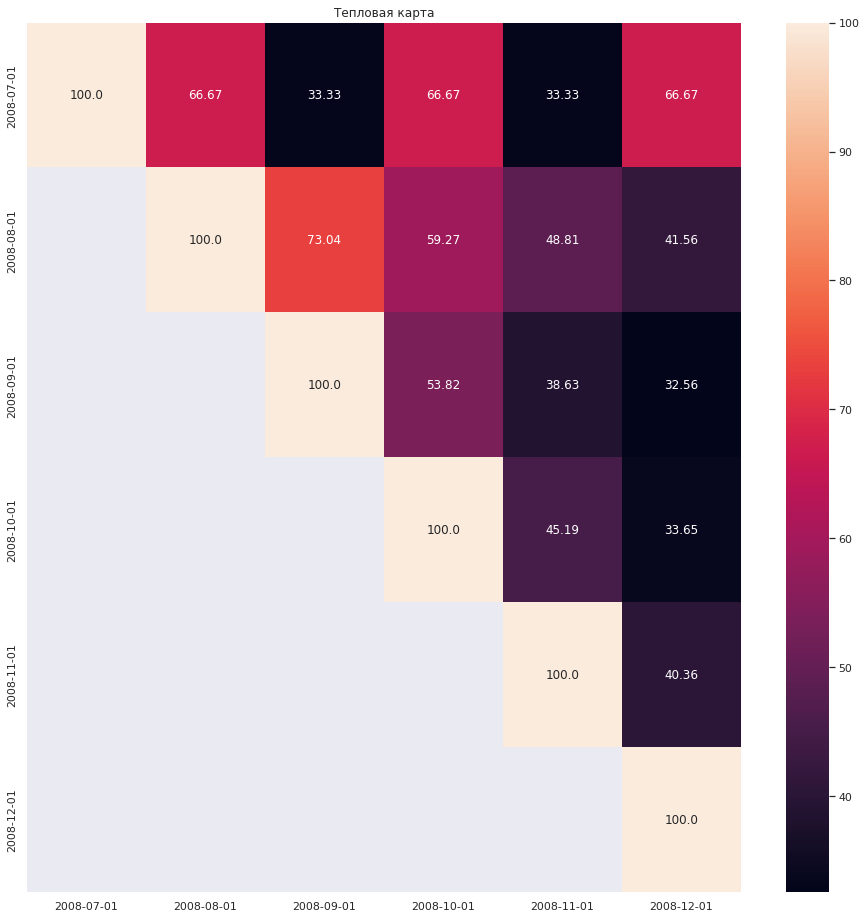

In [30]:
retention = df.pivot("cohort_dt", "session_date", "retention_rate")
retention.index = [str(x)[0:10] for x in retention.index]
retention.columns = [str(x)[0:10] for x in retention.columns]

sns.set(rc={"figure.figsize": (16, 16)})
sns.heatmap(retention, annot=True, fmt="")
plt.title("Тепловая карта")
plt.show()

При взгляде на тепловую карту, бросается в глаза первая строка, где коэффициент удержания осцеллирует между 33 и 67%. Впрочем, если зяглянуть в данные, это легко объяснимо: в июлбской когорте всего 3 пользователя (очевидно, рпазработчиким платформы). Также несколько выбивается большим значением августовская когорта во втором месяце (73,04%), но это можно объяснить эффектом новизны.

# Задание 9


На сколько процентов менялось количество постов ежемесячно с 1 сентября по 31 декабря 2008 года? Отобразите таблицу со следующими полями:

- номер месяца;
- количество постов за месяц;
- процент, который показывает, насколько изменилось количество постов в текущем месяце по сравнению с предыдущим.

Если постов стало меньше, значение процента должно быть отрицательным, если больше — положительным. Округлите значение процента до двух знаков после запятой.

Напомним, что при делении одного целого числа на другое в PostgreSQL в результате получится целое число, округлённое до ближайшего целого вниз. Чтобы этого избежать, переведите делимое в тип `numeric`.

| creation_month | posts_count | percentage |
| -------------- | ----------- | ---------- |
| 9 | 70731 | Nan |
| 10 | 63102 | -10.33 |
| ... | ... | ... |

In [31]:
query = """
SELECT
    month AS creation_month,
    posts_count,
    round( (
            posts_count - lag(posts_count) OVER (
                ORDER BY month
            )
        ) * 100.0 / lag(posts_count) OVER (
            ORDER BY month
        ), 2
    ) percentage
FROM (
    SELECT DISTINCT EXTRACT(
            month
            FROM
                creation_date
        ) AS month,
        COUNT(*) OVER (
            PARTITION BY EXTRACT(
                month
                FROM creation_date
            )
        ) posts_count
    FROM stackoverflow.posts
) a
WHERE month BETWEEN 9 and 12
"""

df = pd.read_sql_query(query, con=engine)

<details>

<summary>Подсказка</summary>
Эту задачу стоит декомпозировать. Сформируйте запрос, который отобразит номер месяца и количество постов. Затем можно использовать оконную функцию, которая вернёт значение за предыдущий месяц, и посчитать процент.
</details>

Постройте круговую диаграмму с количеством постов по месяцам.

In [32]:
df

,creation_month,posts_count,percentage
0,9.0,70371,NaN
1,10.0,63102,-10.33
2,11.0,46975,-25.56
3,12.0,44592,-5.07


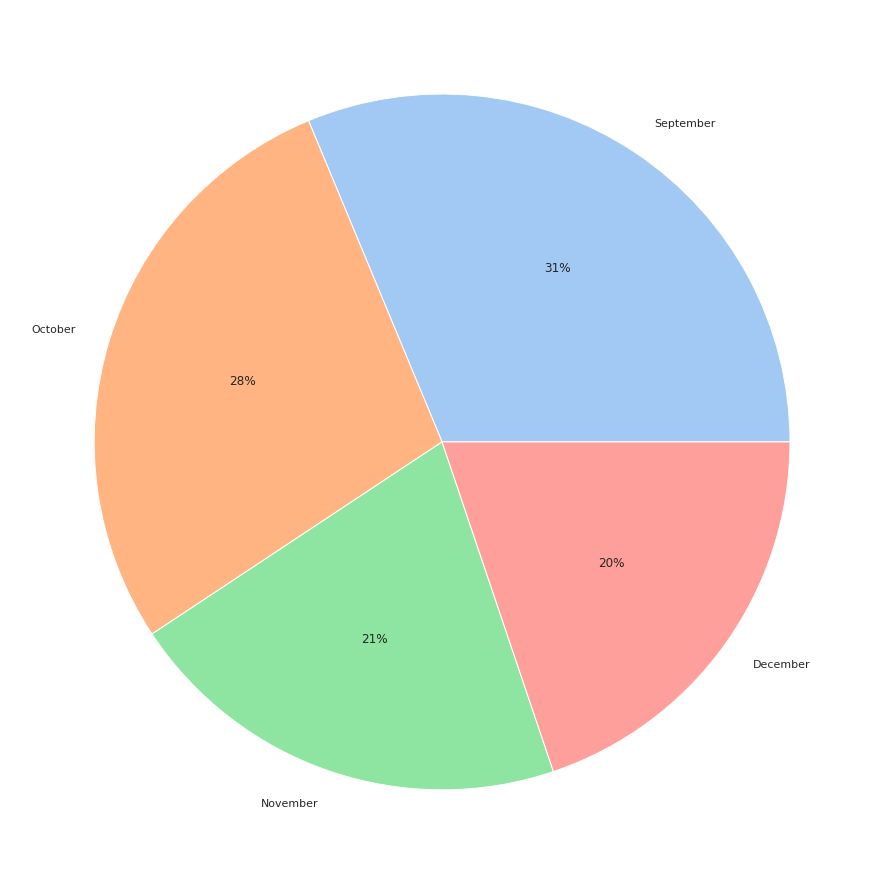

In [33]:
sns.set(rc={"figure.figsize": (16, 16)})
months = ["September", "October", "November", "December"]
plt.pie(
    df["posts_count"],
    labels=months,
    colors=sns.color_palette("pastel")[0:6],
    autopct="%.0f%%",
);

# Задание 10

Выгрузите данные активности пользователя, который опубликовал больше всего постов за всё время. Выведите данные за октябрь 2008 года в таком виде:

- номер недели;
- дата и время последнего поста, опубликованного на этой неделе.

| week_creation | creation_date |
| ------------- | ------------- |
| 40 | 2008-10-05 09:00:58 |
| 41 | 2008-10-12 21:22:23 |
| ... | ... |

In [34]:
query = """
SELECT DISTINCT EXTRACT(
        week
        FROM
            creation_date
    ) week_creation,
    last_value(creation_date) OVER (
        PARTITION BY EXTRACT(
            week
            FROM creation_date
        )
        ORDER BY
            creation_date ROWS BETWEEN UNBOUNDED PRECEDING AND
            UNBOUNDED FOLLOWING
    )
FROM stackoverflow.posts
WHERE user_id IN (
        SELECT user_id
        FROM (
            SELECT
                DISTINCT user_id,
                COUNT(*) OVER (PARTITION BY user_id) AS posts
            FROM stackoverflow.posts
            ORDER BY posts desc
            LIMIT 1
        ) a
    ) AND EXTRACT(MONTH FROM creation_date) = 10
"""

df = pd.read_sql_query(query, con=engine)

<details>

<summary>Подсказка</summary>
Декомпозируйте задачу:
1) Найдите пользователя, который опубликовал больше всего постов. 2) Найдите дату и время создания каждого поста этого пользователя и номер недели. 
3) Отобразите данные только о последних постах пользователя. Для этого можно использовать оконную функцию.
</details>

In [35]:
df

,week_creation,last_value
0,40.0,2008-10-05 09:00:58
1,41.0,2008-10-12 21:22:23
2,42.0,2008-10-19 06:49:30
3,43.0,2008-10-26 21:44:36
4,44.0,2008-10-31 22:16:01
